## Importing libraries

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm as tt


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Analysis

In [2]:
# Reading the .csv file
data = pd.read_csv(r"D:\Data\Basic_Sentiment_Classification\data\data.csv")
data.head()

,textID,text,sentiment
0,2a0463352b,that`s enough! I`ll do nothing for 2 hours.,neutral
1,f358968122,I have to go clothes shopping tomorrow I hate...,negative
2,449e7733f1,i am bored. :| any idea`s of a nice site?,neutral
3,6099baf6e8,I don`t think will want to come back (guys r...,negative
4,f946da7a04,_thomas if only the drinking game was tonight....,neutral


In [3]:
# cheking to see the number of data points we have
data.shape

(18899, 3)

In [4]:
# taking a look at a random text to see how it looks 
data.loc[50, 'text']

'woke up way later than I intended to today  Need to start getting to bed before 5 a.m. b/c this will be a bad habit to break later'

In [5]:
# Looking at the Data distribution
data['sentiment'].value_counts()
# Not the best but, seems fairly balanced

neutral     11118
negative     7781
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

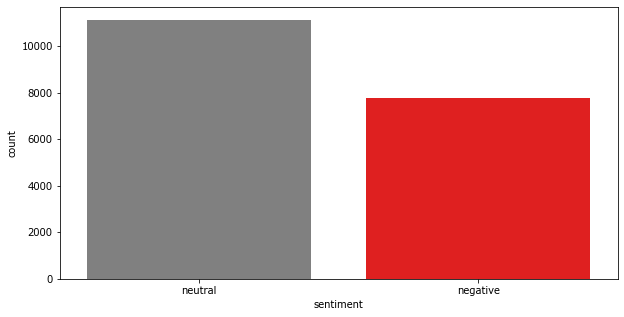

In [6]:
plt.figure(figsize = (10, 5))
sns.countplot(x = 'sentiment', data = data, palette = ['grey', 'red'] )

In [7]:
data.describe()

,textID,text,sentiment
count,18899,18898,18899
unique,18899,18888,2
top,2a0463352b,I see,neutral
freq,1,2,11118


In [8]:
# Finding out the number of null values it may contain
data.info()
# There seems to be one

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18899 entries, 0 to 18898
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     18899 non-null  object
 1   text       18898 non-null  object
 2   sentiment  18899 non-null  object
dtypes: object(3)
memory usage: 443.1+ KB


In [9]:
# Taking a look at the null value
data[data['text'].isnull()]

,textID,text,sentiment
8384,fdb77c3752,NaN,neutral


In [10]:
# Removing the Null value
data.dropna(inplace = True)
# Dropping duplicates
data.drop_duplicates(inplace = True)

In [11]:
# Create a new column to keep track of the number of words in the text
data['Num_words'] = ((data['text'].str.split()).str.len()).astype('int')
data

,textID,text,sentiment,Num_words
0,2a0463352b,that`s enough! I`ll do nothing for 2 hours.,neutral,8
1,f358968122,I have to go clothes shopping tomorrow I hate...,negative,20
2,449e7733f1,i am bored. :| any idea`s of a nice site?,neutral,10
3,6099baf6e8,I don`t think will want to come back (guys r...,negative,12
4,f946da7a04,_thomas if only the drinking game was tonight....,neutral,15
...,...,...,...,...
18894,4fdc228bbe,"back at school again. almost weekend. oh wait,...",neutral,16
18895,07726716b7,Bit devastated that I lost my entire documents...,negative,13
18896,082b93228a,Last night in Australia,neutral,4
18897,82d99a5bec,painting,neutral,1


In [12]:
# Adding a new boolean column which states if the text is negative or not using one-hot encoding

data['negative'] = pd.get_dummies(data['sentiment'])['negative']
data

,textID,text,sentiment,Num_words,negative
0,2a0463352b,that`s enough! I`ll do nothing for 2 hours.,neutral,8,0
1,f358968122,I have to go clothes shopping tomorrow I hate...,negative,20,1
2,449e7733f1,i am bored. :| any idea`s of a nice site?,neutral,10,0
3,6099baf6e8,I don`t think will want to come back (guys r...,negative,12,1
4,f946da7a04,_thomas if only the drinking game was tonight....,neutral,15,0
...,...,...,...,...,...
18894,4fdc228bbe,"back at school again. almost weekend. oh wait,...",neutral,16,0
18895,07726716b7,Bit devastated that I lost my entire documents...,negative,13,1
18896,082b93228a,Last night in Australia,neutral,4,0
18897,82d99a5bec,painting,neutral,1,0


Text(0.5, 1.0, 'Number of words by Sentiment')

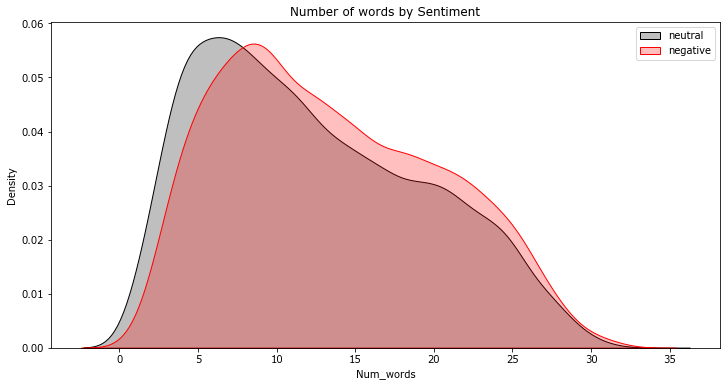

In [13]:
#plot a density plot to see the distribution of words across sentiments 

plt.figure(figsize = (12,6))
p1 = sns.kdeplot(data[data['sentiment'] == 'neutral']['Num_words'], shade = True, color = "k")
    
p2 = sns.kdeplot(data[data['sentiment'] == 'negative']['Num_words'], shade = True, color = "r")

plt.legend(data['sentiment'])
plt.title("Number of words by Sentiment")

<font size="4">
----------------------------------------------------------------------------------------------------------------------------------------------
This plot shows that the "negative" text is typically longer

</font>

## Data preprocessing

In [14]:
#creating a function for cleaning our data

def clean_text(text):
    text = text.lower() # converting everything to lowercase
    text = re.sub("\`", "'", text) # Replacing the weird apostraphe with the typical one
    text = re.sub("[^a-zA-Z ]+", '', text) # Removing any punctuations
    text = re.sub('\w*\d\w*', '', text) # Removing any digits
    
    return text

In [15]:
data_cleaned = data.copy()

In [16]:
data_cleaned['text'] = data_cleaned['text'].apply(lambda x : clean_text(x))

In [17]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)])


data_cleaned['text'] = data_cleaned.text.apply(lemmatize_text)
data_cleaned['text']

0                    thats enough ill do nothing for hours
1        i have to go clothe shop tomorrow i hate it bu...
2                       i be bore any ideas of a nice site
3        i dont think will want to come back guy read y...
4        thomas if only the drink game be tonighti dont...
                               ...                        
18894    back at school again almost weekend oh wait i ...
18895    bite devastate that i lose my entire document ...
18896                              last night in australia
18897                                                paint
18898           be in bed not able to sleep bloody bipolar
Name: text, Length: 18898, dtype: object

In [18]:
# removing stopwords (common words which don't add much meaning to the sentence like "I", "The" )
stop = stopwords.words('english')
new_stopwords = ["i'm", "im", "u", "get", "go", "work", "day", "today", "one"]
stop.extend(new_stopwords)
data_cleaned['text'] = data_cleaned['text'].apply(lambda x : ' '.join([item for item in x.split() if item not in stop]))
data_cleaned['text']

0                           thats enough ill nothing hours
1        clothe shop tomorrow hate serious clothe fall ...
2                                     bore ideas nice site
3                   dont think want come back guy read dms
4            thomas drink game tonighti dont till tomorrow
                               ...                        
18894    back school almost weekend oh wait gotta eight...
18895    bite devastate lose entire document folder hom...
18896                                 last night australia
18897                                                paint
18898                        bed able sleep bloody bipolar
Name: text, Length: 18898, dtype: object

In [19]:
# Adding a new column with the words split  
data_cleaned['temp_list'] = data_cleaned['text'].apply(lambda x : str(x).split())

In [20]:
# Let's take a look at the text we saw before to see how it changed
data_cleaned.loc[50, 'text']
# Looks like it did the job

'wake way later intend need start bed bc bad habit break later'

In [21]:
# Re-evaluating the "Num_words" column after cleaning the data
data_cleaned['Num_words'] = ((data_cleaned['text'].str.split()).str.len()).astype('int')
data_cleaned

,textID,text,sentiment,Num_words,negative,temp_list
0,2a0463352b,thats enough ill nothing hours,neutral,5,0,"[thats, enough, ill, nothing, hours]"
1,f358968122,clothe shop tomorrow hate serious clothe fall ...,negative,9,1,"[clothe, shop, tomorrow, hate, serious, clothe..."
2,449e7733f1,bore ideas nice site,neutral,4,0,"[bore, ideas, nice, site]"
3,6099baf6e8,dont think want come back guy read dms,negative,8,1,"[dont, think, want, come, back, guy, read, dms]"
4,f946da7a04,thomas drink game tonighti dont till tomorrow,neutral,7,0,"[thomas, drink, game, tonighti, dont, till, to..."
...,...,...,...,...,...,...
18894,4fdc228bbe,back school almost weekend oh wait gotta eight...,neutral,10,0,"[back, school, almost, weekend, oh, wait, gott..."
18895,07726716b7,bite devastate lose entire document folder hom...,negative,8,1,"[bite, devastate, lose, entire, document, fold..."
18896,082b93228a,last night australia,neutral,3,0,"[last, night, australia]"
18897,82d99a5bec,paint,neutral,1,0,[paint]


In [22]:
from collections import Counter

#Finding the top words used in this dataset
top = Counter([item for sublist in data_cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap = "YlOrRd")

,Common_words,count
0,like,964
1,dont,961
2,miss,891
3,cant,815
4,think,796
5,want,772
6,know,747
7,time,739
8,feel,667
9,see,660


In [23]:
# Finding the top words by sentiment

Negative_sentiment = data_cleaned[data_cleaned['sentiment'] == 'negative']
Neutral_sentiment = data_cleaned[data_cleaned['sentiment'] == 'neutral']

In [24]:
#Most common neutral words
top_neu = Counter([item for sublist in Neutral_sentiment['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top_neu.most_common(20))
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap = 'Greys')

,Common_words,count
0,dont,493
1,like,475
2,time,467
3,lol,455
4,know,451
5,want,449
6,think,444
7,see,438
8,back,412
9,make,359


In [25]:
#Most common negative words
top_neg = Counter([item for sublist in Negative_sentiment['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top_neg.most_common(20))
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap = 'Reds')

,Common_words,count
0,miss,663
1,like,489
2,dont,468
3,cant,466
4,feel,466
5,sad,389
6,think,352
7,sorry,340
8,really,339
9,want,323


In [26]:
# visualizing using one of the most text visualization tools "Word clouds"

dict_neutral = dict(zip(temp_neutral['Common_words'], temp_neutral['count']))
dict_negative = dict(zip(temp_negative['Common_words'], temp_negative['count']))

word_clouds_neutral = WordCloud(background_color = 'white', colormap = 'Greys').generate_from_frequencies(dict_neutral)
word_clouds_negative = WordCloud(background_color = 'white', colormap = 'Reds').generate_from_frequencies(dict_negative)

(-0.5, 399.5, 199.5, -0.5)

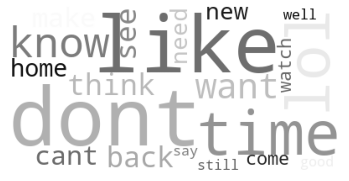

In [27]:
plt.imshow(word_clouds_neutral)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

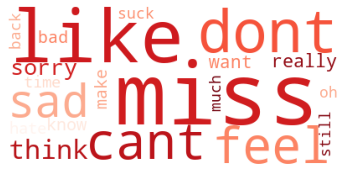

In [28]:
plt.imshow(word_clouds_negative)
plt.axis('off')

<font size="4">
---------------------------------------------------------------------------------------------------------------------------------------------- 
As we would expect from the "negative" sentiment there are words like "sad", "sorry", "bad", "hate" among the most popular words used, but on the other hand we have the word "like" as the second most used word. 

This could imply that the combination of two words like "don't like", "can't like" is also important in defining the sentiment of the text.

This gives us a better idea for our next step....Tokenization
</font>

In [29]:
#Tokenization using the "CountVectorizer" from sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vector = CountVectorizer(ngram_range = (1, 2))# Tokenizing in bigrams based on our EDA earlier with count vectorizer
Tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 2))# Tokenizing in bigrams based on our EDA earlier with Tfidf vectorizer

In [30]:
#splitting the Data into train-test before vectorization
from sklearn.model_selection import train_test_split

features = "text"
target = "negative"
X_train, X_test, y_train, y_test  = train_test_split(data_cleaned[features], data_cleaned[target], test_size = 0.2, random_state = 45)

In [31]:
print("Size of training data : ", X_train.shape[0])
print("Size of testing data : ", X_test.shape[0])

Size of training data :  15118
Size of testing data :  3780


In [32]:
# Vectorizing our text data

X_train_vector_cv = count_vector.fit_transform(X_train)
X_test_vector_cv = count_vector.transform(X_test)

X_train_vector_Tf = Tfidf_vectorizer.fit_transform(X_train)
X_test_vector_Tf = Tfidf_vectorizer.transform(X_test)

<font size = "4">
----------------------------------------------------------------------------------------------------------------------------------------------
Let's try to use something simple first like, Logistic Regression 
</font>

### Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()# Defining the model

In [34]:
lr.fit(X_train_vector_cv, y_train)# Fitting our data and training our model

LogisticRegression()

In [35]:
lr_pred_cv = lr.predict(X_test_vector_cv) # Predicting using our test data
lr_pred_cv[:10]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=uint8)

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      2169
           1       0.80      0.60      0.68      1611

    accuracy                           0.76      3780
   macro avg       0.77      0.74      0.75      3780
weighted avg       0.77      0.76      0.76      3780



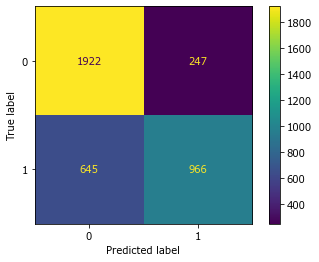

In [36]:
# Visualizing our model performance

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(y_test, lr_pred_cv))

cm_lr = confusion_matrix(y_test, lr_pred_cv)

ConfusionMatrixDisplay(confusion_matrix = cm_lr, display_labels = lr.classes_).plot()
plt.show()

In [37]:
lr.fit(X_train_vector_Tf, y_train)# Fitting our data and training our model

LogisticRegression()

In [38]:
lr_pred_Tf = lr.predict(X_test_vector_Tf) # Predicting using our test data
lr_pred_Tf[:10]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=uint8)

              precision    recall  f1-score   support

           0       0.74      0.88      0.80      2169
           1       0.78      0.59      0.67      1611

    accuracy                           0.76      3780
   macro avg       0.76      0.73      0.74      3780
weighted avg       0.76      0.76      0.75      3780



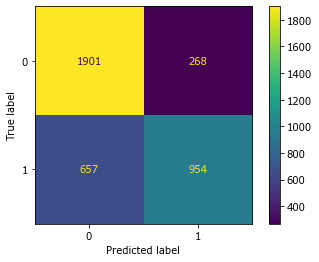

In [39]:
# Visualizing our model performance

print(classification_report(y_test, lr_pred_Tf))

cm_lr = confusion_matrix(y_test, lr_pred_Tf)

ConfusionMatrixDisplay(confusion_matrix = cm_lr, display_labels = lr.classes_).plot()
plt.show()

<font size="4">
----------------------------------------------------------------------------------------------------------------------------------------------  
For a simple model this seems to be doing quite well, but our main objective is decreasing the number of False negatives and in turn the "Recall" which can be better.
    
So, let's try something a little more complicated.
</font>

### Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators = 200, criterion = "entropy") # Defining the model

In [41]:
rf_classifier.fit(X_train_vector_cv, y_train) # Fitting our data and training our model

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [42]:
rf_pred_cv = rf_classifier.predict(X_test_vector_cv)
rf_pred_cv[:10]

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=uint8)

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      2169
           1       0.75      0.62      0.68      1611

    accuracy                           0.75      3780
   macro avg       0.75      0.73      0.74      3780
weighted avg       0.75      0.75      0.75      3780



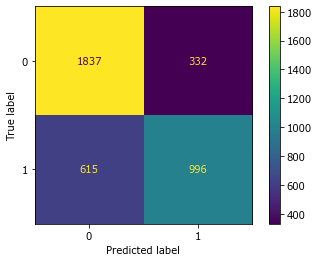

In [43]:
# Visualizing our model performance

print(classification_report(y_test, rf_pred_cv))

cm_rf = confusion_matrix(y_test, rf_pred_cv)

ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = rf_classifier.classes_).plot()
plt.show()

In [44]:
rf_classifier.fit(X_train_vector_Tf, y_train) # Fitting our data and training our model

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [45]:
rf_pred_Tf = rf_classifier.predict(X_test_vector_Tf)
rf_pred_Tf[:10]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=uint8)

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      2169
           1       0.78      0.61      0.68      1611

    accuracy                           0.76      3780
   macro avg       0.76      0.74      0.74      3780
weighted avg       0.76      0.76      0.75      3780



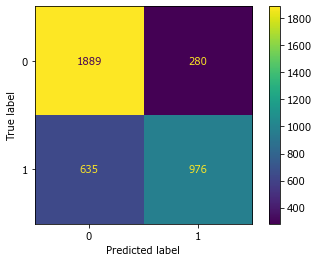

In [46]:
# Visualizing our model performance

print(classification_report(y_test, rf_pred_Tf))

cm_rf = confusion_matrix(y_test, rf_pred_Tf)

ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = rf_classifier.classes_).plot()
plt.show()

<font size="4">
----------------------------------------------------------------------------------------------------------------------------------------------
The model performance seems to be just slightly better but it still isn't ideal.

So, let's try something else.
</font>

### Naive Baye's

In [47]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB() # Defining the model

In [48]:
nb_classifier.fit(X_train_vector_cv.toarray(), y_train) # Fitting our data and training our model

MultinomialNB()

In [49]:
nb_pred = nb_classifier.predict(X_test_vector_cv.toarray())
nb_pred[:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0], dtype=uint8)

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      2169
           1       0.73      0.55      0.63      1611

    accuracy                           0.72      3780
   macro avg       0.72      0.70      0.70      3780
weighted avg       0.72      0.72      0.71      3780



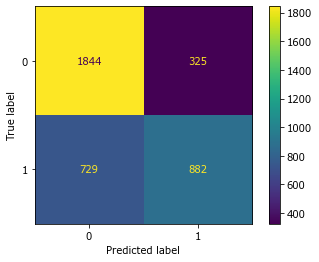

In [50]:
# Visualizing our model performance

print(classification_report(y_test, nb_pred))

cm_nb = confusion_matrix(y_test, nb_pred)

ConfusionMatrixDisplay(confusion_matrix = cm_nb, display_labels = nb_classifier.classes_).plot()
plt.show()

In [51]:
nb_classifier.fit(X_train_vector_Tf.toarray(), y_train) # Fitting our data and training our model

MultinomialNB()

In [52]:
nb_pred_Tf = nb_classifier.predict(X_test_vector_Tf.toarray())
nb_pred_Tf[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

              precision    recall  f1-score   support

           0       0.66      0.96      0.78      2169
           1       0.87      0.33      0.48      1611

    accuracy                           0.69      3780
   macro avg       0.77      0.65      0.63      3780
weighted avg       0.75      0.69      0.66      3780



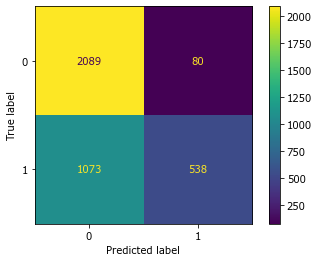

In [53]:
# Visualizing our model performance

print(classification_report(y_test, nb_pred_Tf))

cm_nb = confusion_matrix(y_test, nb_pred_Tf)

ConfusionMatrixDisplay(confusion_matrix = cm_nb, display_labels = nb_classifier.classes_).plot()
plt.show()

<font size="4">
----------------------------------------------------------------------------------------------------------------------------------------------
The accuracy of our model seems to have increased, but our evaluation-metric "Recall" seems to be much lower than before, so this model is not Ideal for our use case.
</font>

## Deep learning models

In [54]:
from keras.models import Model, Sequential
from keras import layers
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.metrics import Recall
from keras.optimizers import Adam

In [55]:
# Tokenizing the train data and converting into sequences with padding
max_words = 1000
max_len = 150
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, maxlen = max_len)

### LSTM

In [56]:
# Defining our model
def model():
    inputs = Input(name='inputs',shape = [max_len])
    layer = Embedding(max_words,50,input_length = max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(128,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    # layer = Dropout(0.5)(layer)
    layer = Dense(1,name = 'out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs = inputs,outputs = layer)
    
    return model

In [57]:
# compiling the model
lstm_model = model()
lstm_model.summary()
lstm_model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00005),metrics = ['accuracy', Recall()])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 128)               8320      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 129       
                                                                 
 activation_1 (Activation)   (None, 1)                 0     

In [58]:
# Fitting our data to the model with Recall as the evalution metric
history_lstm = lstm_model.fit(sequences_matrix, y_train, batch_size = 64, epochs = 10, validation_split = 0.2 , class_weight = {0:1, 1:2.5})

Epoch 1/10
189/189 [==============================] - 15s 61ms/step - loss: 1.0893 - accuracy: 0.4071 - recall: 0.9931 - val_loss: 0.7746 - val_accuracy: 0.4170 - val_recall: 1.0000
Epoch 2/10
189/189 [==============================] - 11s 59ms/step - loss: 1.0605 - accuracy: 0.4059 - recall: 1.0000 - val_loss: 0.7662 - val_accuracy: 0.4170 - val_recall: 1.0000
Epoch 3/10
189/189 [==============================] - 12s 62ms/step - loss: 1.0557 - accuracy: 0.4059 - recall: 1.0000 - val_loss: 0.7799 - val_accuracy: 0.4170 - val_recall: 1.0000
Epoch 4/10
189/189 [==============================] - 12s 63ms/step - loss: 1.0457 - accuracy: 0.4059 - recall: 1.0000 - val_loss: 0.7698 - val_accuracy: 0.4170 - val_recall: 1.0000
Epoch 5/10
189/189 [==============================] - 12s 65ms/step - loss: 1.0227 - accuracy: 0.4059 - recall: 1.0000 - val_loss: 0.7296 - val_accuracy: 0.4170 - val_recall: 1.0000
Epoch 6/10
189/189 [==============================] - 12s 66ms/step - loss: 0.9837 - accur

In [59]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen = max_len)

In [60]:
lstm_model.evaluate(test_sequences_matrix, y_test)# evaluating on test data

119/119 [==============================] - 1s 12ms/step - loss: 0.5806 - accuracy: 0.7135 - recall: 0.7635


[0.5806441903114319, 0.7134920358657837, 0.7635009288787842]

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])


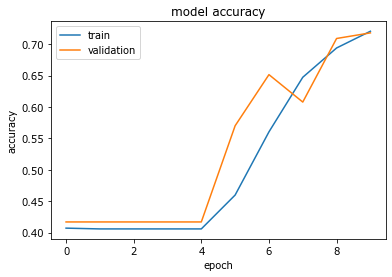

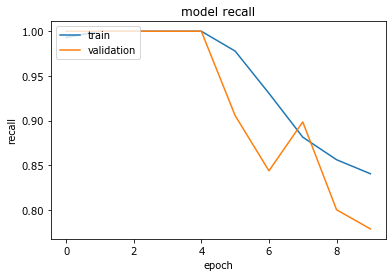

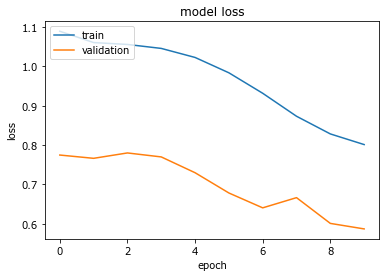

In [61]:
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for recall
plt.plot(history_lstm.history['recall'])
plt.plot(history_lstm.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<font size="4">
----------------------------------------------------------------------------------------------------------------------------------------------
This seems to be the best model so far, I assigned higher weights for the 'negative' sentiment to convey to the algorithm to focus more on this class. 
We can't increase the weights too much because that would bring down the accuracy of model which isn't the best thing to do. 
</font>

## ---------------------------------------------------------------------------------------------------------

## Conclusion:
## So, after using all these different models the LSTM model gives the best result, it still can be improved with maybe making the model more complex by adding more neurons, making the model deeper or maybe some hyper-parameter tuning and running it for longer. 

## We could also try using different models like Bi-directional LSTM, CNN or maybe even some transfer-learning with pretrained models like BERT.

## Machine learning is a never ending practice we can always try to improve the results, so we have stop at some point and consider the time and resourses spent on a project and i think this is a good point to end for now.